<a href="https://colab.research.google.com/github/michellerodrigues/meu-checklist-tarefas-api/blob/main/MVP_Michelle_Rodrigues_MeuChecklistTarefas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparação de Modelos de Aprendizado de Máquinas para problemas de classificação em texto

## Meu Checklist Tarefas
Meu Checklist tarefas é uma aplicação onde o usuário pode acompanhar as tarefas de acordo com suas recorrências.
Na primeira entreva do MVP, entreguei um website com o painel do usuário, onde o usuário novo respondia algumas perguntas e essas perguntas listavam as tarefas elegíveis para seu estilo de vida.
Essas tarefas pertenciam a categorias e essas as categorias organizavam seus cards no painel.

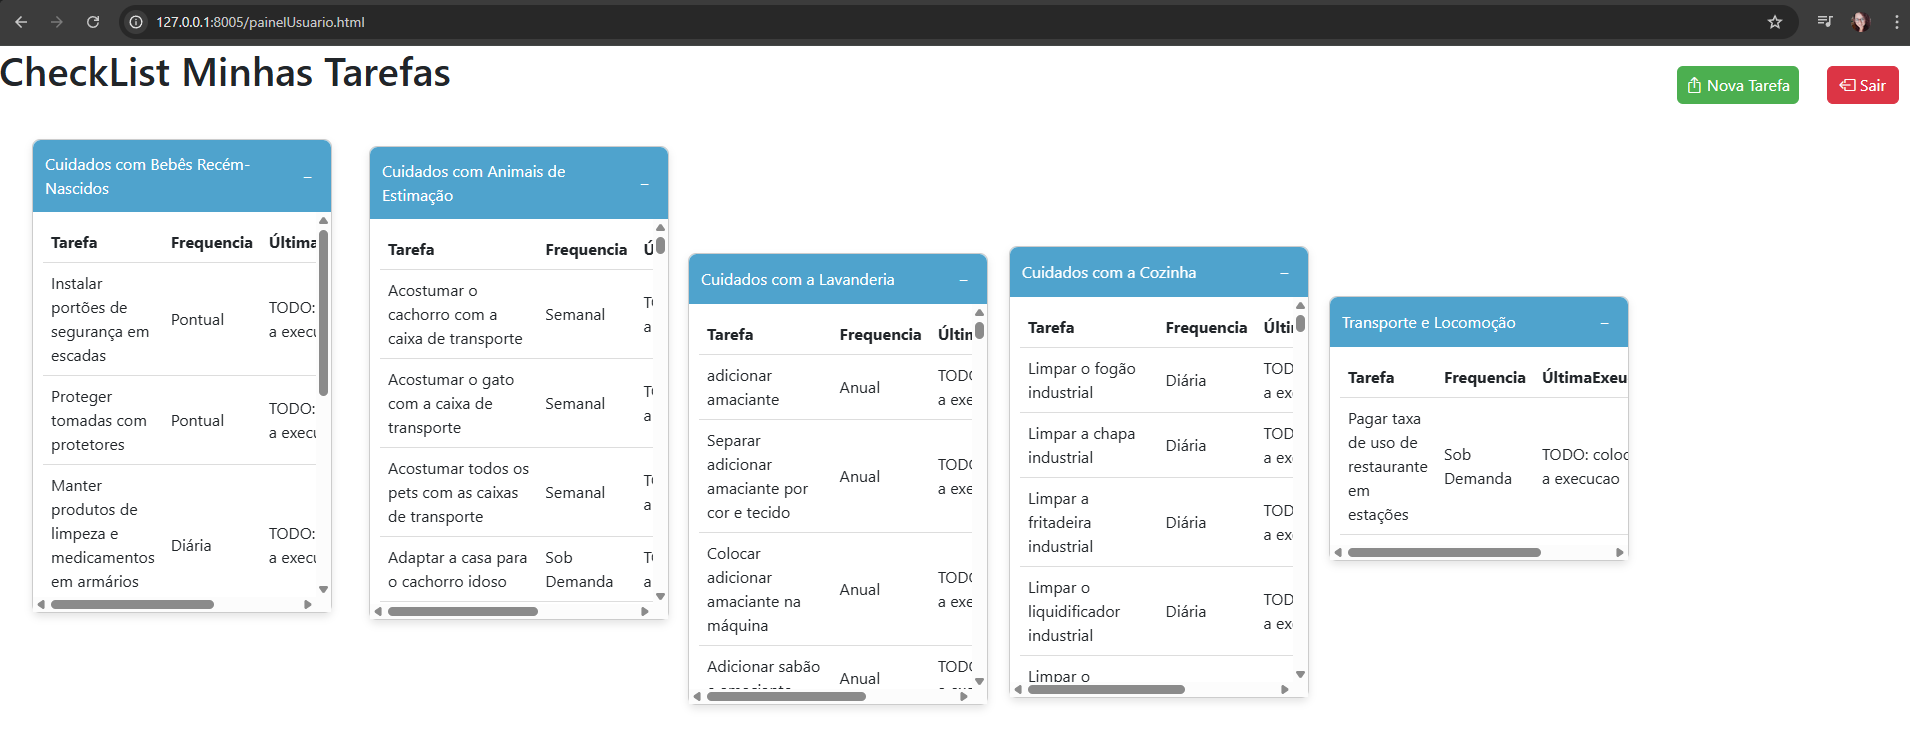

Inicialmente, o usuário começava sua jornada apenas com a resposta inicial do questionário, para "popular" seu painel.

Com esta segunda entrega, decidi promover o Software Inteligente onde o usuário pode cadastrar uma tarefa e o algoritmo prevê automaticamente a categoria para a tarefa digitada. Facilitando a vida do usuário.

Caso a categoria não seja satisfatória, ainda assim, o usuário pode selecionar a categoria disponível (ainda não está liberada o cadastro de novas categorias)

Uma vez inserida a tarefa, ela aparecerá na categoria correta, disponível no painel do usuário.

Para atender ao modelo de classificação, está disponível um arquivo .pkl com cerca de 10k tarefas classificadas em suas categorias.

(caminho do arquivo)

Para ver o funcionamento desta aplicação, assista ao vídeo disponível:  <a href="https://www.youtube.com/watch?v=J5EoOjXckBQ">LINK DO YOUTUBE</a>.

<center>
  <a href="https://www.youtube.com/watch?v=J5EoOjXckBQ" target="_blank">
  <img alt='Miniatura da apresentação do vídeo' src="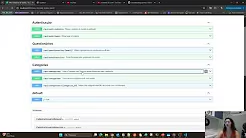)" height="188" width="336">
  </a>
</center>



<div class="markdown-google-sans">
  <h2>O que é o Colab?</h2>
</div>

O Colab, ou "Colaboratory", permite escrever e executar Python no navegador e conta com o seguinte:
- Nenhuma configuração necessária
- Acesso a GPUs sem custo financeiro
- Compartilhamento fácil

Não importa se você <strong>estuda</strong>, <strong>é cientista de dados</strong> ou <strong>pesquisa sobre IA</strong>, o Colab pode facilitar seu trabalho. Assista <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Introdução ao Colab</a> ou <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y">Recursos do Colab que você talvez não conheça</a> para saber mais ou simplesmente comece a usar abaixo!

<div class="markdown-google-sans">

## <strong>NOTEBOOK APRENDIZADO DE MÁQUINA</strong>
</div>



In [ ]:
from __future__ import annotations

import pickle


import time

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from models.categoria import CategoriaModel
from models.categoria import TarefaModel
from nltk.corpus import stopwords
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import select
from sqlalchemy.orm import Session

from database.database import engine

# Configurações iniciais
nltk.download('stopwords')
stop_words_pt = stopwords.words('portuguese')


class DatasetTarefas:
  """Definição da classe que vai ser o nosso dataset"""
    def __init__(self):
        self.tarefa = []
        self.categoria = []

    def to_dict(self):
        return {'tarefa': self.tarefa, 'categoria': self.categoria}


def obter_dataset() -> DatasetTarefas:
    """Obtém o dataset do arquivo PKL. """
    dataset = DatasetTarefas()

    try:
        with open('dataset_tarefas.pkl', 'rb') as arquivo:
            dados = pickle.load(arquivo)

            dataset.tarefa = dados['tarefa']
            dataset.categoria = dados['categoria']
    except FileNotFoundError:
        raise Exception("Arquivo .pkl não encontrado.")

    return dataset


#========================INICIO DO PROCESSAMENTO==================

dataset = obter_dataset()

# Criação do DataFrame
print('\nCriando DataFrame...')
df = pd.DataFrame(dataset.to_dict())

# Pré-processamento
print('\nPré-processamento dos dados...')
le = LabelEncoder()
df['categoria_encoded'] = le.fit_transform(df['categoria'])

# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(
    df['tarefa'],
    df['categoria_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['categoria_encoded'],
)


# Função para avaliar modelos
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    start_time = time.time()

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"\n{model_name} - Cross-validation scores: {cv_scores}")
    print(f"{model_name} - Média CV accuracy: {np.mean(cv_scores):.4f}")

    # Treino e teste
    model.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    print(f"{model_name} - Acurácia no treino: {train_acc:.4f}")
    print(f"{model_name} - Acurácia no teste: {test_acc:.4f}")

    # Relatório de classificação
    y_pred = model.predict(X_test)
    print(f"\nRelatório de classificação para {model_name}:")
    print(
        classification_report(y_test, y_pred, zero_division=0,
                              target_names=le.classes_),
    )

    print(f"Tempo de execução: {time.time() - start_time:.2f} segundos")

    return {
        'model': model,
        'name': model_name,
        'cv_mean': np.mean(cv_scores),
        'train_acc': train_acc,
        'test_acc': test_acc,
        'time': time.time() - start_time,
    }


# Definindo os modelos
models = [
    (
        'Naive Bayes',
        make_pipeline(TfidfVectorizer(stop_words=stop_words_pt),
                      MultinomialNB()),
    ),
    (
        'KNN',
        make_pipeline(
            TfidfVectorizer(stop_words=stop_words_pt),
            StandardScaler(with_mean=False),
            KNeighborsClassifier(),
        ),
    ),
    (
        'Árvore de Decisão',
        make_pipeline(
            TfidfVectorizer(stop_words=stop_words_pt),
            DecisionTreeClassifier(random_state=42),
        ),
    ),
    (
        'SVM',
        make_pipeline(
            TfidfVectorizer(stop_words=stop_words_pt),
            StandardScaler(with_mean=False),
            SVC(probability=True, random_state=42),
        ),
    ),
]


# Otimização de hiperparâmetros para cada modelo:
    # Para 'Naive Bayes' vamos testar 4 formas de 'suavização' para o alpha
    #     (Laplace smoothing) ==> Quanto mais alto (2.0), mais suavização
    #     e evita probabilidade zero caso a tarefa não se encaixe em
    #     nenhuma categoria ou não esteja presente no modelo de treinamento.

    # Para 'KNN' vamos testar com os vizinhos 3, 5 e 7 mais próximos.
    #     n_neighbors: Número de vizinhos a considerar (Quanto maior o número
    #     de vizinhos (7), mais 'justo' de advinhar)
    #     Para esses 3 parâmetros, vamo considera o peso (como esses vizinhos
    #     contribuem para a classificação, Sendo: uniform (todos com peso igual)
    #     distance (Vizinhos mais próximos têm maior peso)
    #     OU seja, serão 6 combinações para o KNN.

    # Para 'Árvore de Decisão' vamos testar com os vizinhos 3, 5 e 7 mais próximos.
    #     n_neighbors: Número de vizinhos a considerar (Quanto maior o número
    #     de vizinhos (7), mais 'justo' de advinhar)
    #     Para esses 3 parâmetros, vamo considera o peso (como esses vizinhos
    #     contribuem para a classificação, Sendo: uniform (todos com peso igual)
    #     distance (Vizinhos mais próximos têm maior peso)
    #     OU seja, serão 6 combinações para o KNN.


param_grids = {
    'Naive Bayes': {'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]},
    'KNN': {
        'kneighborsclassifier__n_neighbors': [3, 5, 7],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
    },
    'Árvore de Decisão': {
        'decisiontreeclassifier__max_depth': [None, 10, 20, 30],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    },
    'SVM': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
}

# Treinamento e avaliação dos modelos
results = []
best_models = {}

for name, model in models:
    print(f"\n=== Processando modelo: {name} ===")

    # GridSearchCV para otimização de hiperparâmetros
    grid_search = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, verbose=1)

    print(f"Otimizando hiperparâmetros para {name}...")
    grid_search.fit(X_train, y_train)

    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    # Avaliação do melhor modelo
    result = evaluate_model(
        best_model, X_train, y_train, X_test, y_test, f"{name} (Otimizado)",
    )
    results.append(result)

# Comparação dos modelos
print('\n=== Comparação dos Modelos ===')
comparison = pd.DataFrame(results)
print(comparison[['name', 'cv_mean', 'train_acc', 'test_acc', 'time']])

# Visualização dos resultados
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='test_acc', data=comparison)
plt.title('Acurácia nos Testes por Modelo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('comparacao_modelos.png')
plt.close()

# Ensemble com os melhores modelos
print('\nCriando ensemble com os melhores modelos...')
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()], voting='soft',
)

ensemble_result = evaluate_model(ensemble, X_train, y_train, X_test, y_test, 'Ensemble')
results.append(ensemble_result)


# Função para prever categoria com threshold
def prever_categoria(tarefa, threshold=0.45):
    probas = ensemble.predict_proba([tarefa])[0]
    max_proba = max(probas)

    if max_proba < threshold:
        return 'Outros'

    encoded = ensemble.predict([tarefa])[0]
    return le.inverse_transform([encoded])[0]


# Exemplos de uso
test_cases = [
    'substituir escovas de dente',
    'instalar sistema de irrigação das plantas',
    'organizar calendário de provas',
    'Comprar protetor de colchão para idosos',
    'recarregar o bilhete do metrô',
]

print('\nTestando o modelo ensemble:')
for task in test_cases:
    print(f"A tarefa '{task}' pertence à categoria: {prever_categoria(task)}")

# Salvando o melhor modelo e recursos
to_persist = {
    'model': ensemble,
    'label_encoder': le,
    'vectorizer': best_models['Naive Bayes'].named_steps['tfidfvectorizer'],
    'metadata': {
        'created_at': pd.Timestamp.now(),
        'version': '2.0',
        'description': 'Modelo de classificação de tarefas com ensemble otimizado',
        'performance': comparison.to_dict(),
    },
}

joblib.dump(to_persist, 'melhor_modelo_tarefas.joblib')
print("\nModelo salvo com sucesso em 'melhor_modelo_tarefas.joblib'")


86400

Para executar o código na célula acima, clique nela e depois pressione o botão Play à esquerda do código ou use o atalho do teclado "Command/Ctrl+Enter". Para editar o código, basta clicar na célula e começar a editar.

As variáveis definidas em uma célula podem ser usadas mais tarde em outras células:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Os notebooks do Colab permitem combinar <strong>código executável</strong> e <strong>rich text</strong> em um só documento, além de <strong>imagens</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> e muito mais. Quando você cria seus próprios notebooks do Colab, eles são armazenados na sua conta do Google Drive. É possível compartilhar os notebooks do Colab facilmente com colegas de trabalho ou amigos e permitir que eles façam comentários ou até editem o documento. Para saber mais, consulte a <a href="/notebooks/basic_features_overview.ipynb">Visão Geral do Colab</a>. Para criar um novo bloco do Colab, use o menu Arquivo acima ou acesse o seguinte: <a href="http://colab.research.google.com#create=true">criar um novo bloco do Colab</a>.

Os notebooks do Colab são notebooks do Jupyter hospedados no Colab. Para saber mais sobre o projeto Jupyter, acesse <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Ciência de dados
</div>

Com o Colab, você pode aproveitar todo o potencial das conhecidas bibliotecas Python para analisar e ver dados. A célula de códigos abaixo usa <strong>numpy</strong> para gerar dados aleatórios e <strong>matplotlib</strong> para visualizá-los. Para editar o código, basta clicar na célula e começar a editar.

É possível importar para os notebooks do Colab os dados da sua conta do Google Drive, como planilhas. Também é possível importar do GitHub e de muitas outras fontes. Para saber mais sobre como importar dados e como o Colab pode ser usado para a ciência de dados, consulte o link abaixo em <a href="#working-with-data">Como trabalhar com dados</a>.

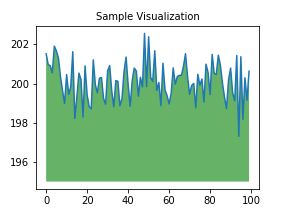

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Os blocos do Colab executam código nos servidores em nuvem do Google. Isso significa que você pode aproveitar a potência de hardware do Google, como <a href="#using-accelerated-hardware">GPUs e TPUs</a>, independente da capacidade da sua máquina. Você só precisa de um navegador.

Por exemplo, se você quiser terminar a execução do código do <strong>pandas</strong> mais rápido, mude para um ambiente de execução de GPU e use bibliotecas como o <a href="https://rapids.ai/cudf-pandas">cuDF do RAPIDS</a>, que oferecem aceleração sem mudança de código.

Para saber mais sobre como acelerar o pandas no Colab, veja o <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb">guia de 10 minutos</a> ou a
 <a href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb">demonstração de análise de dados da bolsa de valores dos EUA</a>.

<div class="markdown-google-sans">

## Machine learning
</div>

Com o Colab, é possível importar um conjunto de dados de imagem, treinar um classificador de imagens dentro dele e avaliar o modelo, tudo com apenas <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">algumas linhas de código</a>.

O Colab é usado amplamente pela comunidade de machine learning, para aplicações como:
- Começar a usar o TensorFlow
- Desenvolvimento e treinamento de redes neurais
- Experimentos com TPUs
- Divulgação de pesquisas em IA
- Criação de tutoriais

Para acessar notebooks do Colab que demonstram aplicações de machine learning, consulte os <a href="#machine-learning-examples">exemplos de machine learning</a> abaixo.

<div class="markdown-google-sans">

## Mais recursos

### Como trabalhar com Notebooks no Colab

</div>

- [Visão geral do Colab](/notebooks/basic_features_overview.ipynb)
- [Guia sobre Markdown](/notebooks/markdown_guide.ipynb)
- [Importar bibliotecas e instalar dependências](/notebooks/snippets/importing_libraries.ipynb)
- [Salvar e carregar notebooks no GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Formulários interativos](/notebooks/forms.ipynb)
- [Widgets interativos](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Como trabalhar com dados
</div>

- [Carregar dados: Drive, Planilhas e Google Cloud Storage](/notebooks/io.ipynb)
- [Gráficos: visualizar dados](/notebooks/charts.ipynb)
- [Começar a usar o BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Aprendizado de máquina

<div>

Estes são alguns notebooks relacionados ao aprendizado de máquina, incluindo o curso on-line do Google sobre o assunto. Acesse o <a href="https://developers.google.com/machine-learning/crash-course/">site do curso completo</a> para saber mais.
- [Introdução ao Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Introdução ao cuDF do RAPIDS para acelerar o Pandas](https://nvda.ws/rapids-cudf)
- [Como usar o modo acelerador do cuML &#40;em inglês&#41;](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [Regressão linear com tf.keras e uso de dados sintéticos](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Usar hardware acelerado
</div>

- [TensorFlow com GPUs](/notebooks/gpu.ipynb)
- [TPUs no Colab](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Exemplos em destaque

</div>

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Treinar novamente um classificador de imagens</a>: crie um modelo do Keras com base em um classificador de imagens pré-treinado para distinguir flores.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Classificação de texto</a>: classifique avaliações de filmes do IMDB como <em>positivas</em> ou <em>negativas</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Transferência de estilo</a>: use o aprendizado profundo para transferir o estilo entre imagens.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Perguntas e respostas sobre o codificador de frases universais multilíngue</a>: use um modelo de machine learning para responder a perguntas do conjunto de dados SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Interpolação de vídeo</a>: preveja o que aconteceu em um vídeo entre o primeiro e o último frames.
